# PRÁCTICA 2: Clasificador de tweets.
# Raúl Barrantes Pampillo
Se extraen tweets de 4 cuentas de twitter; 2 con características parecidas, y 2 con características diferentes; se hace el análisis y vectorización y basándose en estas características se construyen clasificadores, los cuales predicen los modelos.

### Instalación y descarga de librerías

Primero se descargan e instalan la serie de librerías necesarias para el funcionamiento del código:

In [ ]:
pip install -U scikit-learn
pip install tweepy
pip install vaderSentiment

## Importación de librerías

Se importan las librerías:

**tweepy:** Para extracción de tweets.

**time:** Para que pueda haber un delay en la extracción de tweets, y que no haya bloqueo de peticiones.

**pickle:** Para guardar el dataset en futuras pruebas.

**re:** Aplicar reglas regex en el texto.

**numpy:** Aplicar manipulación de datos y arrays.

**sklearn.feature_extraction.text.TfidfVectorizer:** Para poder hacer analísis del corpus.

**sklearn.feature_extraction.text.CountVectorizer:** Para poder hacer la extructura del corpus.

**sklearn.pipeline.Pipeline:** Ayuda hacer una extructura para procesar el entrenamiento y testing de los datos.

**sklearn.metrics.confusion_matrix, accuracy_score:** Se analiza el análisis de accuracy y la matriz de confusión.

**sklearn.model_selection.train_test_split:** Para dividir los datos en training y test.

**sklearn.svm.SVC:** La construcción del clasificador.

**twokenize:** Funciones de filtrado de entidades HTML y espacios en blanco.

**matplotlib.pyplot:** Para mostrar gráficos.

In [10]:
import tweepy
import time
import pickle
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from twokenize import *
import matplotlib.pyplot as plt

## Librería Tweepy

Se hace uso de la librería Tweepy debido a que cuenta con una mejor documentación y una comunidad de desarrolladores más amplia de la que cuenta python-twitter.

### Autentificación a Twitter

Se autentifica a Twitter usando las siguientes credenciales y claves (las cuales son consumer_key, consumer_secret, access_token y access_token_secret), ya habiéndose creada un Twitter App:

In [38]:
consumer_key= "7jYgeinqCZra4uD73eAJ0lXWy"
consumer_secret = "mJPaxrL0mZmUi5zDcOfYWuq1Omxr6OkgzsIrbDbzCzkgamr7B1"

access_token = "52953260-VGHHcg9QeueAC6QwLmCsLTJrV7qRu1BqWWnt1dj6w"

access_token_secret = "312IRtCmfKpZANUMeeuBSxu2I80xhIOLrbtuaz4dRRJvi"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

### Función para evitar exceso de peticiones en Twitter

En esta función se maneja el exceso de peticiones y detiene el cursor en caso de que ya no hayan más iteraciones disponibles.

In [40]:
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            print ("esperando")
            time.sleep(15 * 60)
        except StopIteration:
            break

## Aspectos generales del análisis

- Se excluyen retweets del análisis.

- Se eliminan del corpus las menciones a otros usuarios las cuales empezan con @.

- Se eliminan los URLs.

- Se normalizan las entidades HTML (se convierte de &amp a &). 

- Una vez hechos estos filtros, si hay un conjunto vacío; no se toma en cuenta dentro del corpus.

## Comparación 1: Bernie Sanders y Joe Biden

La primera comparación es de los candidatos del partido Demócrata en EEUU para el 2020, John Biden y Bernie Sanders, los cuales ambos al ser políticos y del mismo partido político, comparten características similares, pero a la vez pertenecen a corrientes distintas entre sí.

![Biden y Sanders](https://cdn.cnn.com/cnnnext/dam/assets/190507171952-biden-sanders-split-full-169.jpg)

Se hace obtienen los datos usando la función **api.user_timeline**, y por medio del cursor predefinido de tweepy se obtienen los datos de cada cuenta, los de **@BernieSanders** se guardan con una etiqueta 0 y los de **@JoeBiden** se guardan con la etiqueta 1.

In [100]:
corpus = []
for status in limit_handled(tweepy.Cursor(api.user_timeline, id="BernieSanders").items()):
      if not status.retweeted and 'RT @' not in status.text:
          text = squeezeWhitespace(splitEdgePunct(normalizeTextForTagger((re.sub('\n', ' ',(re.sub(r'@.*', '',re.sub(r'http\S+', '', status.text))))))))
          if(text!=''):
              corpus.append([text,0])
            
for status in limit_handled(tweepy.Cursor(api.user_timeline, id="JoeBiden").items()):
      if not status.retweeted and 'RT @' not in status.text:
          if(text!=''):
              corpus.append([text,1])

Por medio de un archivo **pickle** se guardan los datos obtenidos del corpus y se recuperan para su posterior uso.

In [101]:
with open('comparacion1.pickle', 'wb') as handle:
    pickle.dump(corpus, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [3]:
with open('comparacion1.pickle', 'rb') as handle:
     corpus = pickle.load(handle)

Del corpus se dividen los datos en uno de 70% para training y 30% para testing. 

In [4]:
corpus = np.asarray(corpus)

X_train, X_test, y_train, y_test = train_test_split(corpus[:,0], corpus[:,1], test_size=0.30, random_state=42)

Se hace un CountVectorizer el cual amacena la estructura de palabras a usar.

In [5]:
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

Por medio del TfidfTransformer se generan los valores de TFIDF para cada palabra.

In [6]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

X_train_tf = tf_transformer.transform(X_train_counts)

### Pruebas de clasificadores

Se genera el clasificador SVC, y con este y los CountVectorizer y TfidfTransformer, Se crea un Pipeline que une todos los clasificadores en uno solo, se entrena el clasificador y hacen las predicciones. Además se tomaron en cuenta para el análisis las configuraciones que muestran un nivel de accuracy mayor al 70%.

Se hacen las pruebas con diferentes valores de C para los distintos kernel:

#### Kernel='linear' y OVR

Se generan los diferentes valores de accuracy y matrices de confusión.

In [59]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfLinear = SVC(probability=True, kernel='linear', C=i, decision_function_shape= 'ovr')

    text_clfLinear = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfLinear),
                                ])

    text_clfLinear.fit(X_train, y_train)

    predictions = text_clfLinear.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.8220472440944881
Matriz de confusión:
[[547  92]
 [134 497]]
C =1.0
Accuracy:
0.831496062992126
Matriz de confusión:
[[551  88]
 [126 505]]
C =1.5
Accuracy:
0.837007874015748
Matriz de confusión:
[[555  84]
 [123 508]]
C =2.0
Accuracy:
0.837007874015748
Matriz de confusión:
[[564  75]
 [132 499]]
C =2.5
Accuracy:
0.8307086614173228
Matriz de confusión:
[[563  76]
 [139 492]]
C =3.0
Accuracy:
0.8299212598425196
Matriz de confusión:
[[562  77]
 [139 492]]
C =3.5
Accuracy:
0.8244094488188977
Matriz de confusión:
[[560  79]
 [144 487]]
C =4.0
Accuracy:
0.8204724409448819
Matriz de confusión:
[[561  78]
 [150 481]]
C =4.5
Accuracy:
0.8220472440944881
Matriz de confusión:
[[564  75]
 [151 480]]
C =5.0
Accuracy:
0.8181102362204724
Matriz de confusión:
[[562  77]
 [154 477]]
C =5.5
Accuracy:
0.8173228346456692
Matriz de confusión:
[[560  79]
 [153 478]]
C =6.0
Accuracy:
0.8188976377952756
Matriz de confusión:
[[559  80]
 [150 481]]
C =6.5
Accuracy:
0.8188976377952756
Matriz 

En este gráfico se aprecia la evolución del accuracy según los valores de C.

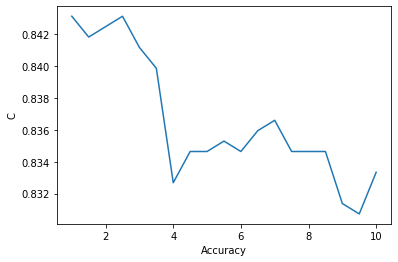

In [15]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='linear' y OVO

Se generan los diferentes valores de accuracy y matrices de confusión.

In [17]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfLinear = SVC(probability=True, kernel='linear', C=i, decision_function_shape= 'ovo')

    text_clfLinear = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfLinear),
                                ])

    text_clfLinear.fit(X_train, y_train)

    predictions = text_clfLinear.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.8169934640522876
Matriz de confusión:
[[527 163]
 [117 723]]
C =1.0
Accuracy:
0.8431372549019608
Matriz de confusión:
[[554 136]
 [104 736]]
C =1.5
Accuracy:
0.8418300653594771
Matriz de confusión:
[[553 137]
 [105 735]]
C =2.0
Accuracy:
0.842483660130719
Matriz de confusión:
[[560 130]
 [111 729]]
C =2.5
Accuracy:
0.8431372549019608
Matriz de confusión:
[[560 130]
 [110 730]]
C =3.0
Accuracy:
0.8411764705882353
Matriz de confusión:
[[554 136]
 [107 733]]
C =3.5
Accuracy:
0.8398692810457516
Matriz de confusión:
[[555 135]
 [110 730]]
C =4.0
Accuracy:
0.8326797385620915
Matriz de confusión:
[[550 140]
 [116 724]]
C =4.5
Accuracy:
0.834640522875817
Matriz de confusión:
[[552 138]
 [115 725]]
C =5.0
Accuracy:
0.834640522875817
Matriz de confusión:
[[551 139]
 [114 726]]
C =5.5
Accuracy:
0.8352941176470589
Matriz de confusión:
[[550 140]
 [112 728]]
C =6.0
Accuracy:
0.834640522875817
Matriz de confusión:
[[548 142]
 [111 729]]
C =6.5
Accuracy:
0.8359477124183007
Matriz d

En este gráfico se aprecia la evolución del accuracy según los valores de C.

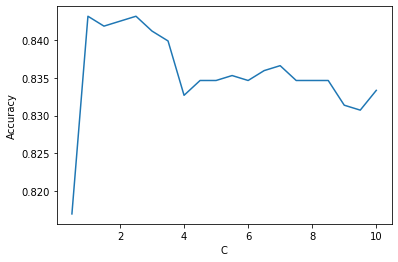

In [19]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='Poly', Gamma=Scale y OVR

Se generan los diferentes valores de accuracy y matrices de confusión.

In [21]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfPoly = SVC(probability=True, kernel='poly', gamma='scale', C=i, decision_function_shape= 'ovr')

    text_clfPoly = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfPoly),
                                ])

    text_clfPoly.fit(X_train, y_train)

    predictions = text_clfPoly.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.730718954248366
Matriz de confusión:
[[304 386]
 [ 26 814]]
C =1.0
Accuracy:
0.8176470588235294
Matriz de confusión:
[[481 209]
 [ 70 770]]
C =1.5
Accuracy:
0.8281045751633986
Matriz de confusión:
[[500 190]
 [ 73 767]]
C =2.0
Accuracy:
0.826797385620915
Matriz de confusión:
[[497 193]
 [ 72 768]]
C =2.5
Accuracy:
0.8281045751633986
Matriz de confusión:
[[492 198]
 [ 65 775]]
C =3.0
Accuracy:
0.8254901960784313
Matriz de confusión:
[[489 201]
 [ 66 774]]
C =3.5
Accuracy:
0.8248366013071895
Matriz de confusión:
[[488 202]
 [ 66 774]]
C =4.0
Accuracy:
0.8235294117647058
Matriz de confusión:
[[484 206]
 [ 64 776]]
C =4.5
Accuracy:
0.8202614379084967
Matriz de confusión:
[[479 211]
 [ 64 776]]
C =5.0
Accuracy:
0.8202614379084967
Matriz de confusión:
[[479 211]
 [ 64 776]]
C =5.5
Accuracy:
0.8183006535947712
Matriz de confusión:
[[476 214]
 [ 64 776]]
C =6.0
Accuracy:
0.8156862745098039
Matriz de confusión:
[[472 218]
 [ 64 776]]
C =6.5
Accuracy:
0.8143790849673203
Matriz

En este gráfico se aprecia la evolución del accuracy según los valores de C.

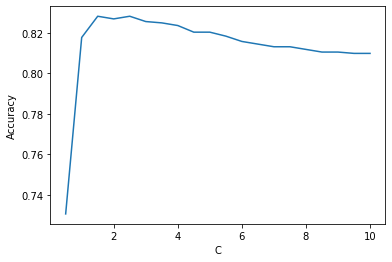

In [22]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='Poly', Gamma=Scale y OVO

Se generan los diferentes valores de accuracy y matrices de confusión.

In [25]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfPoly = SVC(probability=True, kernel='poly', gamma='scale', C=i, decision_function_shape= 'ovo')

    text_clfPoly = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfPoly),
                                ])

    text_clfPoly.fit(X_train, y_train)

    predictions = text_clfPoly.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.730718954248366
Matriz de confusión:
[[304 386]
 [ 26 814]]
C =1.0
Accuracy:
0.8176470588235294
Matriz de confusión:
[[481 209]
 [ 70 770]]
C =1.5
Accuracy:
0.8281045751633986
Matriz de confusión:
[[500 190]
 [ 73 767]]
C =2.0
Accuracy:
0.826797385620915
Matriz de confusión:
[[497 193]
 [ 72 768]]
C =2.5
Accuracy:
0.8281045751633986
Matriz de confusión:
[[492 198]
 [ 65 775]]
C =3.0
Accuracy:
0.8254901960784313
Matriz de confusión:
[[489 201]
 [ 66 774]]
C =3.5
Accuracy:
0.8248366013071895
Matriz de confusión:
[[488 202]
 [ 66 774]]
C =4.0
Accuracy:
0.8235294117647058
Matriz de confusión:
[[484 206]
 [ 64 776]]
C =4.5
Accuracy:
0.8202614379084967
Matriz de confusión:
[[479 211]
 [ 64 776]]
C =5.0
Accuracy:
0.8202614379084967
Matriz de confusión:
[[479 211]
 [ 64 776]]
C =5.5
Accuracy:
0.8183006535947712
Matriz de confusión:
[[476 214]
 [ 64 776]]
C =6.0
Accuracy:
0.8156862745098039
Matriz de confusión:
[[472 218]
 [ 64 776]]
C =6.5
Accuracy:
0.8143790849673203
Matriz

En este gráfico se aprecia la evolución del accuracy según los valores de C.

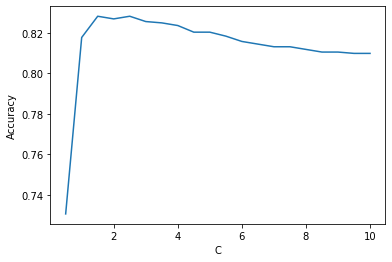

In [27]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='RBF', Gamma=Scale y OVO

Se generan los diferentes valores de accuracy y matrices de confusión.

In [28]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfPoly = SVC(probability=True, kernel='rbf', gamma='scale', C=i, decision_function_shape= 'ovo')

    text_clfPoly = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfPoly),
                                ])

    text_clfPoly.fit(X_train, y_train)

    predictions = text_clfPoly.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.8156862745098039
Matriz de confusión:
[[506 184]
 [ 98 742]]
C =1.0
Accuracy:
0.8398692810457516
Matriz de confusión:
[[539 151]
 [ 94 746]]
C =1.5
Accuracy:
0.8588235294117647
Matriz de confusión:
[[555 135]
 [ 81 759]]
C =2.0
Accuracy:
0.8581699346405228
Matriz de confusión:
[[559 131]
 [ 86 754]]
C =2.5
Accuracy:
0.8588235294117647
Matriz de confusión:
[[560 130]
 [ 86 754]]
C =3.0
Accuracy:
0.8594771241830066
Matriz de confusión:
[[560 130]
 [ 85 755]]
C =3.5
Accuracy:
0.8594771241830066
Matriz de confusión:
[[560 130]
 [ 85 755]]
C =4.0
Accuracy:
0.8601307189542484
Matriz de confusión:
[[561 129]
 [ 85 755]]
C =4.5
Accuracy:
0.8601307189542484
Matriz de confusión:
[[561 129]
 [ 85 755]]
C =5.0
Accuracy:
0.8601307189542484
Matriz de confusión:
[[561 129]
 [ 85 755]]
C =5.5
Accuracy:
0.8601307189542484
Matriz de confusión:
[[561 129]
 [ 85 755]]
C =6.0
Accuracy:
0.8594771241830066
Matriz de confusión:
[[561 129]
 [ 86 754]]
C =6.5
Accuracy:
0.8594771241830066
Matr

En este gráfico se aprecia la evolución del accuracy según los valores de C.

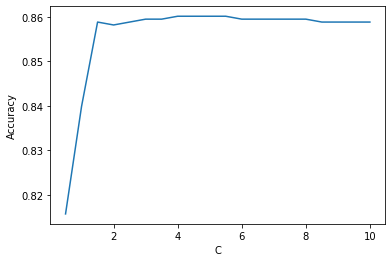

In [29]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='RBF', Gamma=Scale y OVR

Se generan los diferentes valores de accuracy y matrices de confusión.

In [31]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfPoly = SVC(probability=True, kernel='rbf', gamma='scale', C=i, decision_function_shape= 'ovr')

    text_clfPoly = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfPoly),
                                ])

    text_clfPoly.fit(X_train, y_train)

    predictions = text_clfPoly.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.8156862745098039
Matriz de confusión:
[[506 184]
 [ 98 742]]
C =1.0
Accuracy:
0.8398692810457516
Matriz de confusión:
[[539 151]
 [ 94 746]]
C =1.5
Accuracy:
0.8588235294117647
Matriz de confusión:
[[555 135]
 [ 81 759]]
C =2.0
Accuracy:
0.8581699346405228
Matriz de confusión:
[[559 131]
 [ 86 754]]
C =2.5
Accuracy:
0.8588235294117647
Matriz de confusión:
[[560 130]
 [ 86 754]]
C =3.0
Accuracy:
0.8594771241830066
Matriz de confusión:
[[560 130]
 [ 85 755]]
C =3.5
Accuracy:
0.8594771241830066
Matriz de confusión:
[[560 130]
 [ 85 755]]
C =4.0
Accuracy:
0.8601307189542484
Matriz de confusión:
[[561 129]
 [ 85 755]]
C =4.5
Accuracy:
0.8601307189542484
Matriz de confusión:
[[561 129]
 [ 85 755]]
C =5.0
Accuracy:
0.8601307189542484
Matriz de confusión:
[[561 129]
 [ 85 755]]
C =5.5
Accuracy:
0.8601307189542484
Matriz de confusión:
[[561 129]
 [ 85 755]]
C =6.0
Accuracy:
0.8594771241830066
Matriz de confusión:
[[561 129]
 [ 86 754]]
C =6.5
Accuracy:
0.8594771241830066
Matr

En este gráfico se aprecia la evolución del accuracy según los valores de C.

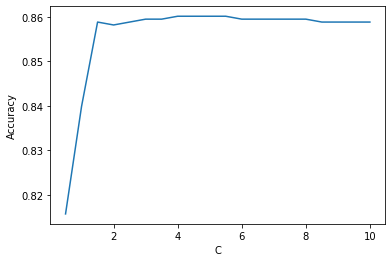

In [32]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

### Mejor resultado

El mejor resultado es de **Kernel= RBF, Gamma=Scale C= 4.0 y OVR**, se escoge el C de **1.0** al ser menor que otros valores de C que obtuvieron el mismo resultado, donde se obtiene una efectividad de predicción del **86.01%**, el cual tiene es la mayor consultada.

Y por medio de la matriz de confusión para tales parámetros, se muestra que con la etiqueta 0 - de Bernie Sanders- acertó 561 veces pero falló en 129, y con la etiqueta 1 - de Joe Biden - acertó 755 veces pero falló 85 veces.

In [ ]:
[[561 129]
 [ 85 755]]

## Comparación 2: Gary Lineker y Ariana Grande

![Ariana y Gary](GARY_ARIANA2.png)

La segunda comparación es con los personajes Gary Lineker, en Twitter como **@garylineker** - exfutbolista inglés y comentarista de televisión - y Ariana Grande, en Twitter como **@arianagrande** - cantante estadounidense de pop -  los cuales pueden tener un corpus muy distinto de tweets entre sí.

Al igual que en el análisis anterior se hace toman los datos, los de Ariana Grande con la etiqueta 0 y los de Gary Lineker con la etiqueta 1.

In [41]:
corpus2 = []

for status in limit_handled(tweepy.Cursor(api.user_timeline, id="arianagrande").items()):
      if not status.retweeted and 'RT @' not in status.text:
          text = squeezeWhitespace(splitEdgePunct(normalizeTextForTagger((re.sub('\n', ' ',(re.sub(r'@.*', '',re.sub(r'http\S+', '', status.text))))))))
          if(text!=''):
              corpus2.append([text,0])
        
count = 0
for status in limit_handled(tweepy.Cursor(api.user_timeline, id="garylineker").items()):
      if not status.retweeted and 'RT @' not in status.text:
          text = squeezeWhitespace(splitEdgePunct(normalizeTextForTagger((re.sub('\n', ' ',(re.sub(r'@.*', '',re.sub(r'http\S+', '', status.text))))))))
          if(text!=''):
              corpus2.append([text,1])


Se guardan los datos en un archivo pickle:

In [42]:
with open('comparacion2.pickle', 'wb') as handle:
    pickle.dump(corpus2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
with open('comparacion2.pickle', 'rb') as handle:
    corpus2 = pickle.load(handle)

Se hace el análisis y división del texto del corpus:

In [44]:
corpus2 = np.array(corpus2)

X_train, X_test, y_train, y_test = train_test_split(corpus2[:,0], corpus2[:,1], test_size=0.30, random_state=42)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)


### Pruebas de clasificadores

Se genera el clasificador SVC, y con este y los CountVectorizer y TfidfTransformer, Se crea un Pipeline que une todos los clasificadores en uno solo, se entrena el clasificador y hacen las predicciones. Además se tomaron en cuenta para el análisis las configuraciones que muestran un nivel de accuracy mayor al 70%.

Se hacen las pruebas con diferentes valores de C para los distintos kernel:

#### Kernel='linear' con OVR

Se generan los diferentes valores de accuracy y matrices de confusión.

In [45]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfLinear = SVC(probability=True, kernel='linear', C=i, decision_function_shape= 'ovr')

    text_clfLinear = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfLinear),
                                ])

    text_clfLinear.fit(X_train, y_train)

    predictions = text_clfLinear.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.8220472440944881
Matriz de confusión:
[[547  92]
 [134 497]]
C =1.0
Accuracy:
0.831496062992126
Matriz de confusión:
[[551  88]
 [126 505]]
C =1.5
Accuracy:
0.837007874015748
Matriz de confusión:
[[555  84]
 [123 508]]
C =2.0
Accuracy:
0.837007874015748
Matriz de confusión:
[[564  75]
 [132 499]]
C =2.5
Accuracy:
0.8307086614173228
Matriz de confusión:
[[563  76]
 [139 492]]
C =3.0
Accuracy:
0.8299212598425196
Matriz de confusión:
[[562  77]
 [139 492]]
C =3.5
Accuracy:
0.8244094488188977
Matriz de confusión:
[[560  79]
 [144 487]]
C =4.0
Accuracy:
0.8204724409448819
Matriz de confusión:
[[561  78]
 [150 481]]
C =4.5
Accuracy:
0.8220472440944881
Matriz de confusión:
[[564  75]
 [151 480]]
C =5.0
Accuracy:
0.8181102362204724
Matriz de confusión:
[[562  77]
 [154 477]]
C =5.5
Accuracy:
0.8173228346456692
Matriz de confusión:
[[560  79]
 [153 478]]
C =6.0
Accuracy:
0.8188976377952756
Matriz de confusión:
[[559  80]
 [150 481]]
C =6.5
Accuracy:
0.8188976377952756
Matriz 

En este gráfico se aprecia la evolución del accuracy según los valores de C.

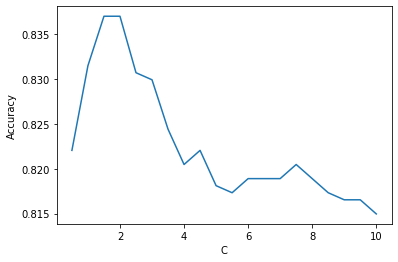

In [47]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='linear' con OVO

Se generan los diferentes valores de accuracy y matrices de confusión.

In [48]:
i = 1
listaC = []
listaAccuracy = []
while i <= 10:

    clfLinear = SVC(probability=True, kernel='linear', C=i, decision_function_shape= 'ovo')

    text_clfLinear = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfLinear),
                                ])

    text_clfLinear.fit(X_train, y_train)

    predictions = text_clfLinear.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =1
Accuracy:
0.831496062992126
Matriz de confusión:
[[551  88]
 [126 505]]
C =1.5
Accuracy:
0.837007874015748
Matriz de confusión:
[[555  84]
 [123 508]]
C =2.0
Accuracy:
0.837007874015748
Matriz de confusión:
[[564  75]
 [132 499]]
C =2.5
Accuracy:
0.8307086614173228
Matriz de confusión:
[[563  76]
 [139 492]]
C =3.0
Accuracy:
0.8299212598425196
Matriz de confusión:
[[562  77]
 [139 492]]
C =3.5
Accuracy:
0.8244094488188977
Matriz de confusión:
[[560  79]
 [144 487]]
C =4.0
Accuracy:
0.8204724409448819
Matriz de confusión:
[[561  78]
 [150 481]]
C =4.5
Accuracy:
0.8220472440944881
Matriz de confusión:
[[564  75]
 [151 480]]
C =5.0
Accuracy:
0.8181102362204724
Matriz de confusión:
[[562  77]
 [154 477]]
C =5.5
Accuracy:
0.8173228346456692
Matriz de confusión:
[[560  79]
 [153 478]]
C =6.0
Accuracy:
0.8188976377952756
Matriz de confusión:
[[559  80]
 [150 481]]
C =6.5
Accuracy:
0.8188976377952756
Matriz de confusión:
[[558  81]
 [149 482]]
C =7.0
Accuracy:
0.8188976377952756
Matriz de

En este gráfico se aprecia la evolución del accuracy según los valores de C.

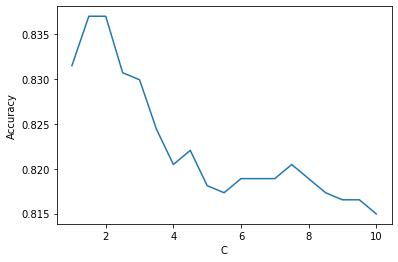

In [49]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='Poly', Gamma=Scale y OVR

Se generan los diferentes valores de accuracy y matrices de confusión.

In [50]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfPoly = SVC(probability=True, kernel='poly', gamma='scale', C=i, decision_function_shape= 'ovr')

    text_clfPoly = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfPoly),
                                ])

    text_clfPoly.fit(X_train, y_train)

    predictions = text_clfPoly.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.7322834645669292
Matriz de confusión:
[[323 316]
 [ 24 607]]
C =1.0
Accuracy:
0.8291338582677166
Matriz de confusión:
[[535 104]
 [113 518]]
C =1.5
Accuracy:
0.8259842519685039
Matriz de confusión:
[[548  91]
 [130 501]]
C =2.0
Accuracy:
0.8141732283464567
Matriz de confusión:
[[560  79]
 [157 474]]
C =2.5
Accuracy:
0.8086614173228347
Matriz de confusión:
[[567  72]
 [171 460]]
C =3.0
Accuracy:
0.7929133858267716
Matriz de confusión:
[[571  68]
 [195 436]]
C =3.5
Accuracy:
0.778740157480315
Matriz de confusión:
[[574  65]
 [216 415]]
C =4.0
Accuracy:
0.7692913385826772
Matriz de confusión:
[[575  64]
 [229 402]]
C =4.5
Accuracy:
0.7543307086614173
Matriz de confusión:
[[577  62]
 [250 381]]
C =5.0
Accuracy:
0.74251968503937
Matriz de confusión:
[[578  61]
 [266 365]]
C =5.5
Accuracy:
0.7338582677165354
Matriz de confusión:
[[580  59]
 [279 352]]
C =6.0
Accuracy:
0.7251968503937007
Matriz de confusión:
[[582  57]
 [292 339]]
C =6.5
Accuracy:
0.7173228346456693
Matriz 

En este gráfico se aprecia la evolución del accuracy según los valores de C.

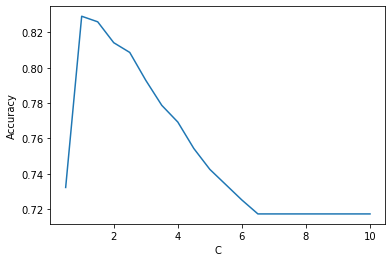

In [51]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='Poly', Gamma=Scale y OVO

Se generan los diferentes valores de accuracy y matrices de confusión.

In [52]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfPoly = SVC(probability=True, kernel='poly', gamma='scale', C=i, decision_function_shape= 'ovo')

    text_clfPoly = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfPoly),
                                ])

    text_clfPoly.fit(X_train, y_train)

    predictions = text_clfPoly.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.7322834645669292
Matriz de confusión:
[[323 316]
 [ 24 607]]
C =1.0
Accuracy:
0.8291338582677166
Matriz de confusión:
[[535 104]
 [113 518]]
C =1.5
Accuracy:
0.8259842519685039
Matriz de confusión:
[[548  91]
 [130 501]]
C =2.0
Accuracy:
0.8141732283464567
Matriz de confusión:
[[560  79]
 [157 474]]
C =2.5
Accuracy:
0.8086614173228347
Matriz de confusión:
[[567  72]
 [171 460]]
C =3.0
Accuracy:
0.7929133858267716
Matriz de confusión:
[[571  68]
 [195 436]]
C =3.5
Accuracy:
0.778740157480315
Matriz de confusión:
[[574  65]
 [216 415]]
C =4.0
Accuracy:
0.7692913385826772
Matriz de confusión:
[[575  64]
 [229 402]]
C =4.5
Accuracy:
0.7543307086614173
Matriz de confusión:
[[577  62]
 [250 381]]
C =5.0
Accuracy:
0.74251968503937
Matriz de confusión:
[[578  61]
 [266 365]]
C =5.5
Accuracy:
0.7338582677165354
Matriz de confusión:
[[580  59]
 [279 352]]
C =6.0
Accuracy:
0.7251968503937007
Matriz de confusión:
[[582  57]
 [292 339]]
C =6.5
Accuracy:
0.7173228346456693
Matriz 

En este gráfico se aprecia la evolución del accuracy según los valores de C.

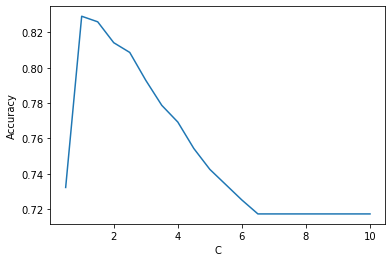

In [53]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='RBF', Gamma=Scale y OVO

Se generan los diferentes valores de accuracy y matrices de confusión.

In [54]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfPoly = SVC(probability=True, kernel='rbf', gamma='scale', C=i, decision_function_shape= 'ovo')

    text_clfPoly = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfPoly),
                                ])

    text_clfPoly.fit(X_train, y_train)

    predictions = text_clfPoly.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.8188976377952756
Matriz de confusión:
[[497 142]
 [ 88 543]]
C =1.0
Accuracy:
0.8401574803149606
Matriz de confusión:
[[533 106]
 [ 97 534]]
C =1.5
Accuracy:
0.8472440944881889
Matriz de confusión:
[[543  96]
 [ 98 533]]
C =2.0
Accuracy:
0.8503937007874016
Matriz de confusión:
[[546  93]
 [ 97 534]]
C =2.5
Accuracy:
0.8519685039370078
Matriz de confusión:
[[548  91]
 [ 97 534]]
C =3.0
Accuracy:
0.852755905511811
Matriz de confusión:
[[549  90]
 [ 97 534]]
C =3.5
Accuracy:
0.8519685039370078
Matriz de confusión:
[[549  90]
 [ 98 533]]
C =4.0
Accuracy:
0.852755905511811
Matriz de confusión:
[[549  90]
 [ 97 534]]
C =4.5
Accuracy:
0.852755905511811
Matriz de confusión:
[[549  90]
 [ 97 534]]
C =5.0
Accuracy:
0.8519685039370078
Matriz de confusión:
[[548  91]
 [ 97 534]]
C =5.5
Accuracy:
0.8543307086614174
Matriz de confusión:
[[549  90]
 [ 95 536]]
C =6.0
Accuracy:
0.8551181102362204
Matriz de confusión:
[[549  90]
 [ 94 537]]
C =6.5
Accuracy:
0.8551181102362204
Matriz 

En este gráfico se aprecia la evolución del accuracy según los valores de C.

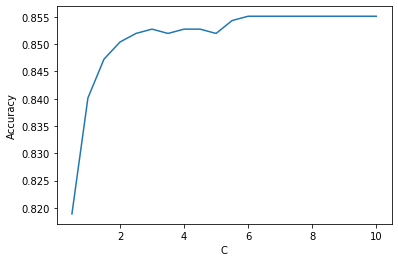

In [55]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

#### Kernel='RBF', Gamma=Scale y OVR

Se generan los diferentes valores de accuracy y matrices de confusión.

In [57]:
i = 0.5
listaC = []
listaAccuracy = []
while i <= 10:

    clfPoly = SVC(probability=True, kernel='rbf', gamma='scale', C=i, decision_function_shape= 'ovr')

    text_clfPoly = Pipeline([('vect', count_vect),
                                ('tfidf', tf_transformer),
                                ('clf', clfPoly),
                                ])

    text_clfPoly.fit(X_train, y_train)

    predictions = text_clfPoly.predict(X_test)
    listaC.append(i)
    accuracy= accuracy_score(y_test, predictions)
    listaAccuracy.append(accuracy)
    print("C ="+str(i))
    print("Accuracy:")
    print(accuracy)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, predictions))
    i=i+0.5

C =0.5
Accuracy:
0.8188976377952756
Matriz de confusión:
[[497 142]
 [ 88 543]]
C =1.0
Accuracy:
0.8401574803149606
Matriz de confusión:
[[533 106]
 [ 97 534]]
C =1.5
Accuracy:
0.8472440944881889
Matriz de confusión:
[[543  96]
 [ 98 533]]
C =2.0
Accuracy:
0.8503937007874016
Matriz de confusión:
[[546  93]
 [ 97 534]]
C =2.5
Accuracy:
0.8519685039370078
Matriz de confusión:
[[548  91]
 [ 97 534]]
C =3.0
Accuracy:
0.852755905511811
Matriz de confusión:
[[549  90]
 [ 97 534]]
C =3.5
Accuracy:
0.8519685039370078
Matriz de confusión:
[[549  90]
 [ 98 533]]
C =4.0
Accuracy:
0.852755905511811
Matriz de confusión:
[[549  90]
 [ 97 534]]
C =4.5
Accuracy:
0.852755905511811
Matriz de confusión:
[[549  90]
 [ 97 534]]
C =5.0
Accuracy:
0.8519685039370078
Matriz de confusión:
[[548  91]
 [ 97 534]]
C =5.5
Accuracy:
0.8543307086614174
Matriz de confusión:
[[549  90]
 [ 95 536]]
C =6.0
Accuracy:
0.8551181102362204
Matriz de confusión:
[[549  90]
 [ 94 537]]
C =6.5
Accuracy:
0.8551181102362204
Matriz 

En este gráfico se aprecia la evolución del accuracy según los valores de C.

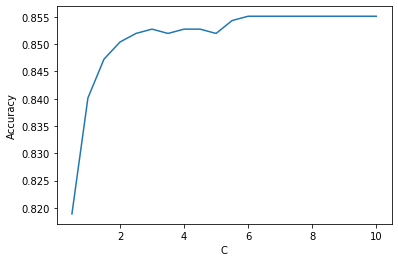

In [58]:
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.plot(listaC, listaAccuracy)

### Mejor resultado

El mejor resultado es de **Kernel= RBF, Gamma=Scale C= 6.0 y OVR**, se escoge el C de **6.0** al ser menor que otros valores de C que obtuvieron el mismo resultado, donde se obtiene una efectividad de predicción del **85.51%**, el cual tiene es la mayor consultada.

Y por medio de la matriz de confusión para dicho clasificador se muestra que con la etiqueta 0 - de Ariana Grande- acertó 549 veces pero falló en 90, y con la etiqueta 1 - de Gary Linkener - acertó 537 veces pero falló 94 veces.

In [ ]:
[[549  90]
 [ 94 537]]

## Análisis de sentimientos usando VADER

Se hace un análisis de sentimientos por medio de la librería VADER, el cual analiza individualmente cada sentencia, con su indice de positividad, negatividad, neutralidad y en un indíce llamado 'compound' que sumariza todos los sentimientos en la escala siguiente:

**Positivo:** >= 0.05

**Neutral:** > -0.05 y < 0.05

**Negativo:** <= -0.05

Se inicializa la función por medio del SentimentIntensityAnalyzer().

In [158]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

Por medio de la siguiente función se genera un promedio de los scores de cada corpus.

In [163]:
def getScores(corpus):
    count = 0
    neg = 0
    neu = 0
    pos = 0
    compound = 0
    for sentence in np.nditer(corpus):
        score = analyser.polarity_scores(str(sentence))
        neg = neg + score["neg"]
        neu = neu + score["neu"]
        pos = pos + score["pos"]
        compound = compound + score["compound"]
        count=count+1
    return {'neg': neg/count, 'neu': neu/count, 'pos': pos/count, 'compound': compound/count}

Se hace un análisis de todos los tweets de cada twitero consultado: 

### Joe Biden:

***Negativo:*** 0.06. ***Neutral:***  0.78. ***Positivo:***  0.13. ***Compound:***  **0.13**. 

El índice compound, al ser mayor que 0.05, indica que tiene un sentimiento **positivo**.

In [165]:
print(getScores(corpus[corpus[:,1] == '1'][:,np.array([True, False])]))

{'neg': 0.06604315789473689, 'neu': 0.7844884210526326, 'pos': 0.1343775438596491, 'compound': 0.13379561403508738}


### Bernie Sanders:

***Negativo:*** 0.09. ***Neutral:***  0.77. ***Positivo:***  0.12. ***Compound:***  **0.02**. 

El índice compound, al ser menor que 0.05 y mayor que -0.05, indica que tiene un sentimiento **neutral**.

In [166]:
print(getScores(corpus[corpus[:,1] == '0'][:,np.array([True, False])]))

{'neg': 0.09863466666666669, 'neu': 0.7703964444444443, 'pos': 0.12118355555555564, 'compound': 0.02427119999999998}


### Gary Lineker:

***Negativo:*** 0.07. ***Neutral:***  0.72. ***Positivo:***  0.19. ***Compound:***  **0.16**. 

El índice compound, al ser mayor que 0.05, indica que tiene un sentimiento **positivo**.

In [167]:
print(getScores(corpus2[corpus2[:,1] == '1'][:,np.array([True, False])]))

{'neg': 0.07483594470046087, 'neu': 0.7260930875576038, 'pos': 0.19907235023041442, 'compound': 0.1653487557603688}


### Ariana Grande

***Negativo:*** 0.05. ***Neutral:***  0.69. ***Positivo:***  0.23. ***Compound:***  **0.22**. 

El índice compound, al ser mayor que 0.05, indica que tiene un sentimiento **positivo**.

In [168]:
print(getScores(corpus2[corpus2[:,1] == '0'][:,np.array([True, False])]))

{'neg': 0.05212660098522166, 'neu': 0.6938384236453197, 'pos': 0.23728719211822655, 'compound': 0.22689881773399104}


## Conclusiones

- Los dos análisis, aunque uno era de personajes casi iguales y otro de personajes diferentes; presentaron resultados muy parecidos.

- Los tweets en general, cuentan con gran variedad de aspectos, por esto para efectos de análisis es mejor normalizar el corpus.

- Con respecto al análisis de sentimientos, la mayoría son positivos, con clara tendencia a ser neutrales.

- El tipo de clasificador RBF mostró los mejores resultados para ambas comparaciones.